<a href="https://colab.research.google.com/github/JangAyeon/ToBigs/blob/master/%5B10%5DUnsupervised_learning_generative_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 투빅스 15기 정규세션 10주차 DCGAN 구현 과제
"빈칸" 부분을 채우는 과제입니다. "빈칸"뿐만 아니라 중간중간 주석 또는 마크다운으로 설명 부탁드립니다  
https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py  
위의 주소는 pytorch dcgan 공식 튜토리얼 코드로 해당 코드를 바탕으로 과제를 만들었습니다. 튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋을 것 같습니다  
다만, 그대로 복붙이 아닌 코드를 이해해 나가면서 과제를 수행해주시기 바랍니다  
마지막 과제인 만큼 다들 화이팅!

## 드라이브 연결

In [ ]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## 패키지 임포트

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

## MNIST 데이터 불러오기
기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)  
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기  
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [ ]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= True,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), #이미지 64x64로 크기 변환
                                                     transforms.ToTensor(), #텐서자료형으로 변환
                                                     transforms.Normalize((0.5,), (0.5,)), #노말라이즈를 통해 -1.~1.의 값을 갖게 변환
                     ]))


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


### 데이터 확인하기

In [ ]:
print('number of training data: ', len(dataset)) #데이터 수 확인
image,_ = dataset[0]

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


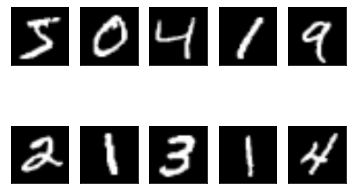

In [ ]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i]
    image = (image+1)/2
    image = image.squeeze()
    np_img = image.numpy()
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

### 데이터 로더 정의

In [ ]:
# dataloader
batch_size = 128 #빈칸
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

## device 정의

In [ ]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 신경망 

In [ ]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images : For color images this is 1 black or while
nz = 100 # size of z latent vector :  size of generator input
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator


### 신경망 가중치 초기화 함수 정의
신경망의 가중치 초기화 방법에 대해 논문에 자세히 나와있습니다.  
다음 사이트는 파이토치에서 가중치 초기화에 관련된 글 입니다  
https://www.javaer101.com/ko/article/1010427.html

In [ ]:
def weights_init(m): 
  #네트워크의 모든 weight들은 mean=0, standard deviation =0.02의 normal distribution의 형태로 초기화
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자 클래스

trasposed convolution 관련 자료: https://yonghyuc.wordpress.com/2019/08/08/transposed-convolutions-aka-deconvolution/

In [ ]:
class Generator(nn.Module): #Generator : input(100,1,1) -> output(1,64,64)
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
           
            #Generator는 featuremap이 2배씩 커져야함으로 originalconvolutionlayer가 아니라 convolution transpose operator를 이용한 dimension 확장 구현
            #100개의 노이즈 벡터로부터 4*4 , 1024개의 channel을 가지는 feature를 생성하는 convolution layer
            #linear vectoor (100,)과 matrix (100,1)의 정보량은 동일
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            
            # state size. (ngf*8) x 4 x 4
            #첫번째 layer가 8배된 커널 사이즈로 input은 ngf*8
            #이전 커널에서 채널 사이즈가 반으로 줄어들어 4*ngf
            #Stride는 x, y 차원 둘 다 2배로 커짐
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),#RELU 사용


            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            #generator의 마지막 layer에서는 RELU를 사용하지 않고 Tanh를 사용
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64

        )

    def forward(self, input):
        #위의 5개의 layer를 연속적으로 연결       #위의 5개의 layer를 연속적으로 연결
                return self.main(input)
        return self.main(input)

In [ ]:
# 총 2개의 네트워크 필요 : Generator 1개 + Discriminator 1개
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 판별자 클래스

**Image를 입력 받은 Discriminator의 출력값**<br>
1) 출력값 >=0.5 : real image<br>
2) 출력값 < 0.5 : fake image (=Generator로 만들어진 Image)로 판단

In [ ]:
class Discriminator(nn.Module): #Discriminator : input(1,64,64) -> output(1,1,1)
 
                                                  
    def __init__(self):  #generator를 그대로 뒤집은 형태로 구현
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #Dimension이 stride에 비례하여 감소해야 하기 때문에 conv2d사용
            #LeakyReLu사용, 기울기는 0.2                                                                     
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            #마지막 layer에서는 LeakyReLU와 Batchnormalization 사용 안함
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() #sigmoid output으로 변경됨

            
        )

    def forward(self, input):
      #처음부터 마지막 layer까지 sequential 하게 연결   
        return  self.main(input)

In [ ]:
# 총 2개의 네트워크 필요 : Generator 1개 + Discriminator 1개
netD = Discriminator().to(device) # 생성자 객체 생성
netD.apply(weights_init) # 위의 정의한 함수로 가중치 초기화

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Function & Optimizer

In [ ]:
# 손실함수 : Binary cross Entropy function 이용 손실함수 : Binary cross Entropy function 이용
criterion = nn.BCELoss() 

real_label = 1.
fake_label = 0.

# optimizer hyperparameters
learning_rate = 0.0002
beta1 =0.5 #default 값인 0.9를 그대로 사용할 경우, train cureve가 oscillation 또는 instability함 -> 0.5로 변경


# optimizers : 네트워크가 2개이므로 optimizer도 2개 optimizers : 네트워크가 2개이므로 optimizer도 2개 
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))  

optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))


## Train
"빈칸"을 채우고, 각각의 변수 및 메소드가 무엇을 나태는지 혹은 어떻게 계산되는지를 주석으로 설명 부탁드립니다.  
참고하면 좋은 사이트: https://redstarhong.tistory.com/64

In [ ]:
num_epochs = 5

#discriminator input으로 들어가는 것이 2가지 : original X 와 generator에 의해 생성된 fake X
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader,0):
        #D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad() # 기울기 초기화
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #forward 계산
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        #loss 계산     
        errD_real = criterion(output, label)
        #gradient 계산       
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device) #100개의 채널, y=1, x=1을 가진 fake noise vector 생성       
        fake = netG(noise) #가짜 이미지 생성       
        label.fill_(fake_label)
        #생성한 가짜 이미지 분류      
        output = netD(fake.detach()).view(-1)
        #fake image에 대한 loss 계산      
        errD_fake = criterion(output, label)
        #해당 batch의 gradient 계산
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        #real image와 fake image의 gradient 합산
        errD =  errD_real + errD_fake
        optimizerD.step()

        #G network: maximize log(D(G(z)))
        netG.zero_grad() # 기울기 초기화
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

[0/5][0/469]	Loss_D: 2.0823	Loss_G: 4.6706	D(x): 0.5662	D(G(z)): 0.6791 / 0.0155
[0/5][50/469]	Loss_D: 0.0720	Loss_G: 8.8980	D(x): 0.9411	D(G(z)): 0.0019 / 0.0002
[0/5][100/469]	Loss_D: 15.0733	Loss_G: 28.2840	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.2110	Loss_G: 4.7825	D(x): 0.9043	D(G(z)): 0.0816 / 0.0109
[0/5][200/469]	Loss_D: 0.1008	Loss_G: 4.7219	D(x): 0.9528	D(G(z)): 0.0475 / 0.0112
[0/5][250/469]	Loss_D: 0.2176	Loss_G: 3.9659	D(x): 0.9074	D(G(z)): 0.0953 / 0.0296
[0/5][300/469]	Loss_D: 0.6982	Loss_G: 2.6590	D(x): 0.6263	D(G(z)): 0.0386 / 0.1150
[0/5][350/469]	Loss_D: 0.2024	Loss_G: 2.8372	D(x): 0.9719	D(G(z)): 0.1426 / 0.0973
[0/5][400/469]	Loss_D: 0.1284	Loss_G: 4.6469	D(x): 0.9656	D(G(z)): 0.0835 / 0.0145
[0/5][450/469]	Loss_D: 0.6674	Loss_G: 2.8627	D(x): 0.8230	D(G(z)): 0.3434 / 0.0747
[1/5][0/469]	Loss_D: 0.3502	Loss_G: 2.4935	D(x): 0.8570	D(G(z)): 0.1601 / 0.1054
[1/5][50/469]	Loss_D: 0.2715	Loss_G: 1.7647	D(x): 0.8322	D(G(z)): 0.0682 / 0.2077
[1/5][10